导包

In [12]:
import ipykernel
import numpy as np
import keras
from keras.datasets import mnist
from keras.models import Model, Sequential
import keras.backend as K
from keras import layers
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

定义超参数

In [26]:
batch_size = 256
pretrain_epochs = 10
finetune_epochs = 10
embedding_dim = 256
margin=0.3
num_classes = 10

定义对比损失函数，选用三元组损失

In [14]:
def triplet_loss(margin):
    def loss(y_true, y_pred):
        total_length = y_pred.shape.as_list()[-1]
        anchor = y_pred[:, 0:int(total_length * 1 / 3)]
        positive = y_pred[:, int(total_length * 1 / 3):int(total_length * 2 / 3)]
        negative = y_pred[:, int(total_length * 2 / 3):int(total_length * 3 / 3)]

        # distance between the anchor and the positive
        pos_dist = K.sum(K.square(anchor - positive), axis=1)
        # distance between the anchor and the negative
        neg_dist = K.sum(K.square(anchor - negative), axis=1)

        return K.maximum(pos_dist - neg_dist + margin, 0.0)

    return loss

自定义DataGenerator生成minibatch的样本图片和标签

In [15]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, y, batch_size, num_classes, pretrain=True):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.data_aug = ImageDataGenerator(
            rotation_range=10,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
        )
        self.pretrain = pretrain

    def __len__(self):
        return int(np.ceil(len(self.x)) / float(self.batch_size))

    def __getitem__(self, index):
        batch_x = self.x[index * self.batch_size: (index + 1) * self.batch_size]
        batch_y = self.y[index * self.batch_size: (index + 1) * self.batch_size]
        if self.pretrain:
          anchor = batch_x
          positive = self.data_aug.flow(anchor, shuffle=False, batch_size=self.batch_size).next()
          negative = np.zeros_like(anchor)

          for i in range(self.batch_size):
              neg_idx = np.random.choice(np.where(self.y != batch_y[i])[0])
              negative[i] = self.x[neg_idx]

          return [anchor, positive, negative], np.zeros((self.batch_size,))
        else:
          return batch_x, batch_y

加载数据集

In [16]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255
input_shape = x_train.shape[1:]

构建骨干网络

In [27]:
backbone = Sequential([
    layers.Conv2D(32, (3, 3), input_shape=input_shape),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),

    layers.Flatten(),

    layers.Dense(256, name='fc1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # layers.Dropout(0.5),

    layers.Dense(embedding_dim, activation='relu')
], name='backbone')
backbone.summary()

Model: "backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        184

构建预训练模型

In [28]:
input_a = layers.Input(shape=input_shape, name="input_a")
input_p = layers.Input(shape=input_shape, name="input_p")
input_n = layers.Input(shape=input_shape, name="input_n")
output_a = backbone(input_a)
output_p = backbone(input_p)
output_n = backbone(input_n)
merged_output = layers.concatenate([output_a, output_p, output_n], axis=-1)
pretrain_model = keras.Model(inputs=[input_a, input_p, input_n], outputs=merged_output)
pretrain_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_p (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input_n (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 backbone (Sequential)          (None, 256)          495872      ['input_a[0][0]',                
                                                                  'input_p[0][0]',          

加载数据，开始预训练

In [29]:
data_generator = DataGenerator(x_train, y_train, batch_size, num_classes)
pretrain_model.compile(loss=triplet_loss(margin=margin), optimizer=Adam())
pretrain_model.fit(data_generator, epochs=pretrain_epochs)

Epoch 1/10
234/234 [==============================] - 31s 124ms/step - loss: 0.1425
Epoch 2/10
234/234 [==============================] - 29s 123ms/step - loss: 0.0191
Epoch 3/10
234/234 [==============================] - 28s 121ms/step - loss: 0.0089
Epoch 4/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0071
Epoch 5/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0060
Epoch 6/10
234/234 [==============================] - 28s 121ms/step - loss: 0.0054
Epoch 7/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0037
Epoch 8/10
234/234 [==============================] - 28s 120ms/step - loss: 0.0042
Epoch 9/10
234/234 [==============================] - 29s 122ms/step - loss: 0.0039
Epoch 10/10
234/234 [==============================] - 28s 121ms/step - loss: 0.0042


tSNE可视化

313/313 [==============================] - 1s 2ms/step


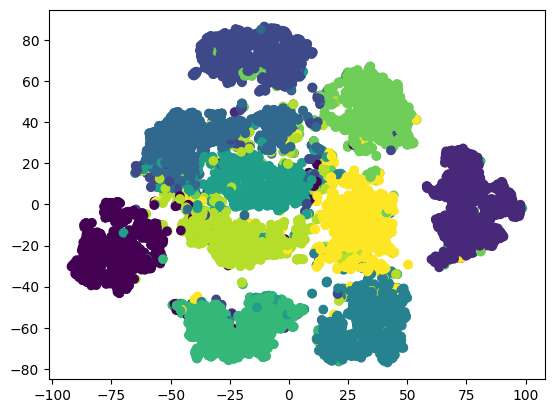

In [20]:
model = pretrain_model.get_layer("backbone")

embeddings = model.predict(x_test)
tsne_embeddings = TSNE(n_components=2).fit_transform(embeddings)

plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=y_test)
plt.show()

构建训练模型

In [30]:
finetune_model = pretrain_model.get_layer("backbone")
for layer in finetune_model.layers:
    layer.trainable = False
finetune_model.add(layers.Dense(128))
finetune_model.add(layers.BatchNormalization())
finetune_model.add(layers.Activation('relu'))
finetune_model.add(layers.Dense(64))
finetune_model.add(layers.BatchNormalization())
finetune_model.add(layers.Activation('relu'))
finetune_model.add(layers.Dense(num_classes, activation='softmax'))

finetune_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
finetune_model.summary()

Model: "backbone"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_10 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 activation_10 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 13, 13, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 11, 11, 64)        184

In [31]:
trainDataLoader = DataGenerator(x_train, y_train, batch_size, num_classes, pretrain=False)
testDataLoader = DataGenerator(x_test, y_test, batch_size, num_classes, pretrain=False)

finetune_model.fit(trainDataLoader, epochs=finetune_epochs)
test_loss, pretrain_acc = finetune_model.evaluate(testDataLoader)
print("Test accuracy:", pretrain_acc)

Epoch 1/10
234/234 [==============================] - 4s 7ms/step - loss: 0.3804 - accuracy: 0.8984
Epoch 2/10
234/234 [==============================] - 2s 6ms/step - loss: 0.1749 - accuracy: 0.9457
Epoch 3/10
234/234 [==============================] - 1s 6ms/step - loss: 0.1550 - accuracy: 0.9516
Epoch 4/10
234/234 [==============================] - 2s 6ms/step - loss: 0.1508 - accuracy: 0.9510
Epoch 5/10
234/234 [==============================] - 1s 6ms/step - loss: 0.1388 - accuracy: 0.9551
Epoch 6/10
234/234 [==============================] - 1s 6ms/step - loss: 0.1349 - accuracy: 0.9567
Epoch 7/10
234/234 [==============================] - 2s 8ms/step - loss: 0.1313 - accuracy: 0.9575
Epoch 8/10
234/234 [==============================] - 2s 7ms/step - loss: 0.1282 - accuracy: 0.9580
Epoch 9/10
234/234 [==============================] - 1s 6ms/step - loss: 0.1266 - accuracy: 0.9583
Epoch 10/10
39/39 [==============================] - 0s 5ms/step - loss: 0.0885 - accuracy: 0.9716
T